# 获取数据

## 源数据
price: https://studio.glassnode.com/metrics?a=ETH&category=&ema=0&m=market.PriceUsdOhlc&mAvg=0&mMedian=0&s=1488326400&u=1709222399&zoom=

nvt ratio: https://studio.glassnode.com/metrics?a=ETH&category=&ema=0&m=indicators.Nvt&mAvg=0&mMedian=0&s=1488326400&u=1709222399&zoom=

## 训练集&测试集：

2017.3.1 - 2023.2.28

## 回测：

2023.3.1 - 2024.2.29

In [291]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

### 读取price数据

In [292]:
df = pd.read_csv('../data/eth_price.csv')
df.drop(df.columns[1], axis=1, inplace=True)
df.columns = ['date', 'close', 'high', 'low', 'open']
df['date'] = pd.to_datetime(df['date'])
df = df[(df['date'] >= '2017-03-01') & (df['date'] <= '2024-02-29')]
df

,date,close,high,low,open
0,2017-03-01,17.758000,17.758000,16.970000,16.970000
1,2017-03-02,19.208000,19.246000,19.144000,19.144000
2,2017-03-03,19.610000,20.040000,19.610000,20.040000
3,2017-03-04,18.702000,18.900000,18.660000,18.834000
4,2017-03-05,19.200000,19.200000,19.150000,19.152000
...,...,...,...,...,...
2552,2024-02-25,3111.157214,3113.612582,3099.943825,3104.313420
2553,2024-02-26,3179.377544,3182.628043,3171.625989,3182.459859
2554,2024-02-27,3243.107970,3250.021864,3240.807238,3250.021864
2555,2024-02-28,3381.199751,3382.843713,3343.736769,3343.736769


### 读取nvt ratio数据

In [293]:
df_nvt = pd.read_csv('../data/ethereum-network-value-to-transactions-ratio-nvt.csv')
df_nvt.columns = ['date', 'nvt ratio']
df_nvt['date'] = pd.to_datetime(df['date'])
df_nvt = df_nvt[(df_nvt['date'] >= '2017-03-01') & (df_nvt['date'] <= '2023-02-28')]
df_nvt

,date,nvt ratio
0,2017-03-01,7.576159
1,2017-03-02,5.164297
2,2017-03-03,5.427846
3,2017-03-04,8.371288
4,2017-03-05,9.768700
...,...,...
2186,2023-02-24,95.804672
2187,2023-02-25,155.020116
2188,2023-02-26,143.036149
2189,2023-02-27,79.292695


### 合并数据

In [294]:
df['NVT'] = df_nvt['nvt ratio']
df['NVT'] = df['NVT'].fillna(method='ffill')
df.to_csv('../data/input.csv')
df.set_index(['date'], inplace = True, drop=True) 
list_feature = list(df.columns)
print(list_feature)
df

['close', 'high', 'low', 'open', 'NVT']


,close,high,low,open,NVT
date,,,,,
2017-03-01,17.758000,17.758000,16.970000,16.970000,7.576159
2017-03-02,19.208000,19.246000,19.144000,19.144000,5.164297
2017-03-03,19.610000,20.040000,19.610000,20.040000,5.427846
2017-03-04,18.702000,18.900000,18.660000,18.834000,8.371288
2017-03-05,19.200000,19.200000,19.150000,19.152000,9.768700
...,...,...,...,...,...
2024-02-25,3111.157214,3113.612582,3099.943825,3104.313420,108.004038
2024-02-26,3179.377544,3182.628043,3171.625989,3182.459859,108.004038
2024-02-27,3243.107970,3250.021864,3240.807238,3250.021864,108.004038


# 多因子LSTM预测模型

### 特征归一化

拟合操作将计算数据的最小值和最大值，然后对数据进行缩放转换，使其落入指定的范围

缩放后的数据被存储在变量scaled中

In [295]:
values = df
values = values.astype('float32')

# 创建一个MinMaxScaler对象，用于将数据缩放到(0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# 使用MinMaxScaler对象对values进行拟合和转换操作
scaled = scaler.fit_transform(values)

scaled

array([[2.4529244e-04, 1.4494103e-04, 9.8947203e-05, 0.0000000e+00,
        1.8328594e-02],
       [5.4722326e-04, 4.5481557e-04, 5.5663171e-04, 4.5626750e-04,
        1.0371499e-02],
       [6.3093100e-04, 6.2016491e-04, 6.5473723e-04, 6.4431550e-04,
        1.1240985e-02],
       ...,
       [6.7185313e-01, 6.7325997e-01, 6.7880189e-01, 6.7853564e-01,
        3.4965530e-01],
       [7.0060766e-01, 7.0091999e-01, 7.0047134e-01, 6.9820404e-01,
        3.4965530e-01],
       [7.1808356e-01, 7.2158784e-01, 7.2548938e-01, 7.2342026e-01,
        3.4965530e-01]], dtype=float32)

### 将数据集转换为监督学习问题

In [296]:
from pandas import DataFrame
from pandas import concat

# 将时间序列数据转换成监督学习问题的格式
def series_to_supervised(data, list_feature, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    # 用于存储特征列和对应的名称
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(list_feature[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(list_feature[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(list_feature[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

n_in = 3  #用过去多少天的特征作为输入
n_out = 2  #预测未来多少天价格
# frame as supervised learning
reframed = series_to_supervised(scaled, list_feature, n_in, n_out)
reframed

,close(t-3),high(t-3),low(t-3),open(t-3),NVT(t-3),close(t-2),high(t-2),low(t-2),open(t-2),NVT(t-2),...,close(t),high(t),low(t),open(t),NVT(t),close(t+1),high(t+1),low(t+1),open(t+1),NVT(t+1)
3,0.000245,0.000145,0.000099,0.000000,0.018329,0.000547,0.000455,0.000557,0.000456,0.010371,...,0.000442,0.000383,0.000455,0.000391,0.020952,0.000546,0.000445,0.000558,0.000458,0.025562
4,0.000547,0.000455,0.000557,0.000456,0.010371,0.000631,0.000620,0.000655,0.000644,0.011241,...,0.000546,0.000445,0.000558,0.000458,0.025562,0.000706,0.000619,0.000728,0.000643,0.012613
5,0.000631,0.000620,0.000655,0.000644,0.011241,0.000442,0.000383,0.000455,0.000391,0.020952,...,0.000706,0.000619,0.000728,0.000643,0.012613,0.000494,0.000439,0.000516,0.000424,0.021820
6,0.000442,0.000383,0.000455,0.000391,0.020952,0.000546,0.000445,0.000558,0.000458,0.025562,...,0.000494,0.000439,0.000516,0.000424,0.021820,0.000000,0.000000,0.000000,0.000004,0.019592
7,0.000546,0.000445,0.000558,0.000458,0.025562,0.000706,0.000619,0.000728,0.000643,0.012613,...,0.000000,0.000000,0.000000,0.000004,0.019592,0.000296,0.000248,0.000316,0.000269,0.013209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,0.615244,0.616486,0.615865,0.613859,0.349655,0.615002,0.618918,0.621808,0.623769,0.349655,...,0.619526,0.619602,0.625160,0.623163,0.349655,0.644377,0.644853,0.649146,0.647955,0.349655
2552,0.615002,0.618918,0.621808,0.623769,0.349655,0.604987,0.606381,0.608755,0.609593,0.349655,...,0.644377,0.644853,0.649146,0.647955,0.349655,0.658583,0.659225,0.664237,0.664356,0.349655
2553,0.604987,0.606381,0.608755,0.609593,0.349655,0.619526,0.619602,0.625160,0.623163,0.349655,...,0.658583,0.659225,0.664237,0.664356,0.349655,0.671853,0.673260,0.678802,0.678536,0.349655
2554,0.619526,0.619602,0.625160,0.623163,0.349655,0.644377,0.644853,0.649146,0.647955,0.349655,...,0.671853,0.673260,0.678802,0.678536,0.349655,0.700608,0.700920,0.700471,0.698204,0.349655


### 拆分为输入矩阵和输出矩阵

根据给定的时间步长（n_in 和 n_out）以及特征名称（list_feature），构造输入特征（X）和目标变量（Y）的列名列表

并从 reframed 中选择对应的列作为输入和输出

t-3, t-2, ..., t-1 是过去10天的实际数据

t, t+1 是预测数据

In [297]:
print(reframed.columns)
list_use_feature = []
for j in range(len(list_feature)):
    for i in range(n_in):
        list_use_feature.append(list_feature[j]+'(t-%d)' % (i+1))
    
X = reframed[list_use_feature]
print('X columns: ',X.columns)

list_use_result = []
list_use_result.append('close(t)')
for i in range(n_out-1):
    list_use_result.append('close(t+%d)' % (i+1))
Y = reframed[list_use_result]
print('Y column: ', Y.columns)

Index(['close(t-3)', 'high(t-3)', 'low(t-3)', 'open(t-3)', 'NVT(t-3)',
       'close(t-2)', 'high(t-2)', 'low(t-2)', 'open(t-2)', 'NVT(t-2)',
       'close(t-1)', 'high(t-1)', 'low(t-1)', 'open(t-1)', 'NVT(t-1)',
       'close(t)', 'high(t)', 'low(t)', 'open(t)', 'NVT(t)', 'close(t+1)',
       'high(t+1)', 'low(t+1)', 'open(t+1)', 'NVT(t+1)'],
      dtype='object')
X columns:  Index(['close(t-1)', 'close(t-2)', 'close(t-3)', 'high(t-1)', 'high(t-2)',
       'high(t-3)', 'low(t-1)', 'low(t-2)', 'low(t-3)', 'open(t-1)',
       'open(t-2)', 'open(t-3)', 'NVT(t-1)', 'NVT(t-2)', 'NVT(t-3)'],
      dtype='object')
Y column:  Index(['close(t)', 'close(t+1)'], dtype='object')


### 拆分为训练集和测试集

将输入特征（X）和目标变量（Y）转换为适合在神经网络中使用的格式，并划分训练集和测试集

对输入特征进行形状调整，使其变成3D张量，其中包括批次大小、时间步长和特征数

In [298]:
print(X.shape, Y.shape)

X = X.values
Y = Y.values
n_train_days = int(X.shape[0]/3)
print('Number of samples in the training set: ', n_train_days)

# 前 n_train_days 个样本作为训练集，其余样本作为测试集
train_X, train_Y = X[:n_train_days, :], Y[:n_train_days, :]
test_X, test_Y = X[n_train_days:, :], Y[n_train_days:, :]

# reshape input to be 3D [batchs, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(2553, 15) (2553, 2)
Number of samples in the training set:  851
(851, 1, 15) (851, 2) (1702, 1, 15) (1702, 2)


### 构建及训练LSTM模型

1.  在模型中添加一个LSTM层，包含50个神经元，并指定输入数据的形状为(train_X.shape[1], train_X.shape[2])

    其中train_X.shape[1]表示时间步长，train_X.shape[2]表示特征数

2.  在模型中添加一个全连接（Dense）层，该层的输出维度与目标变量的维度相同，用于输出预测结果

3.  编译模型，指定损失函数为平均绝对误差（Mean Absolute Error，MAE），优化器为Adam

4.  使用训练数据训练模型，指定训练的迭代次数为50次，批次大小为72，同时使用测试数据进行验证

    verbose=2表示显示每个epoch的训练情况，shuffle=False表示不对数据进行洗牌

5.  绘制训练集和测试集的损失值随着训练迭代次数的变化曲线，分别使用train和test作为标签

Epoch 1/50


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 - 1s - 56ms/step - loss: 0.0524 - val_loss: 0.2548
Epoch 2/50
12/12 - 0s - 2ms/step - loss: 0.0344 - val_loss: 0.1925
Epoch 3/50
12/12 - 0s - 2ms/step - loss: 0.0282 - val_loss: 0.1584
Epoch 4/50
12/12 - 0s - 2ms/step - loss: 0.0244 - val_loss: 0.1392
Epoch 5/50
12/12 - 0s - 2ms/step - loss: 0.0210 - val_loss: 0.1154
Epoch 6/50
12/12 - 0s - 2ms/step - loss: 0.0177 - val_loss: 0.0833
Epoch 7/50
12/12 - 0s - 2ms/step - loss: 0.0138 - val_loss: 0.0471
Epoch 8/50
12/12 - 0s - 2ms/step - loss: 0.0099 - val_loss: 0.0240
Epoch 9/50
12/12 - 0s - 2ms/step - loss: 0.0068 - val_loss: 0.0292
Epoch 10/50
12/12 - 0s - 2ms/step - loss: 0.0056 - val_loss: 0.0419
Epoch 11/50
12/12 - 0s - 2ms/step - loss: 0.0062 - val_loss: 0.0398
Epoch 12/50
12/12 - 0s - 3ms/step - loss: 0.0069 - val_loss: 0.0414
Epoch 13/50
12/12 - 0s - 2ms/step - loss: 0.0083 - val_loss: 0.0323
Epoch 14/50
12/12 - 0s - 2ms/step - loss: 0.0064 - val_loss: 0.0307
Epoch 15/50
12/12 - 0s - 2ms/step - loss: 0.0066 - val_loss: 0.0312

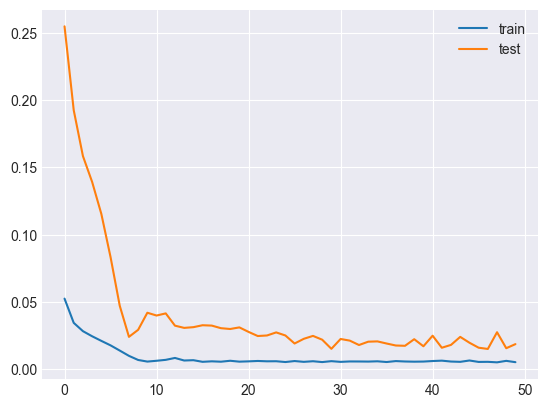

In [299]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

# design network
model = Sequential()   # 创建一个序贯模型，即一个线性层叠模型
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_Y.shape[1]))  # 全连接层
model.compile(loss='mae', optimizer='adam') 
# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 评估模型

predictiony0 和 predictiony1分别表示close(t)和close(t+1)的预测结果

In [300]:
# 使用训练好的模型对测试集数据进行预测
Yhat = model.predict(test_X)
Yhat

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[0.06015757, 0.05873256],
       [0.06129484, 0.06007094],
       [0.06036121, 0.05933747],
       ...,
       [0.65822077, 0.6337503 ],
       [0.6751249 , 0.6499698 ],
       [0.69291157, 0.664801  ]], dtype=float32)

In [301]:
import numpy as np

predict_model = pd.DataFrame(Yhat, columns=['Yhat0', 'Yhat1'])
predict_model.insert(0, 'date', values.index[n_in:-n_out+1][n_train_days:])
print(predict_model)
test_Y_df = pd.DataFrame(test_Y, columns=['testY0', 'testY1'])
test_Y_df.insert(0, 'date', values.index[n_in:-n_out+1][n_train_days:])
print(test_Y_df)

           date     Yhat0     Yhat1
0    2019-07-03  0.060158  0.058733
1    2019-07-04  0.061295  0.060071
2    2019-07-05  0.060361  0.059337
3    2019-07-06  0.060109  0.058527
4    2019-07-07  0.058583  0.057010
...         ...       ...       ...
1697 2024-02-24  0.643063  0.617667
1698 2024-02-25  0.648396  0.621292
1699 2024-02-26  0.658221  0.633750
1700 2024-02-27  0.675125  0.649970
1701 2024-02-28  0.692912  0.664801

[1702 rows x 3 columns]
           date    testY0    testY1
0    2019-07-03  0.059665  0.055772
1    2019-07-04  0.055772  0.056513
2    2019-07-05  0.056513  0.056414
3    2019-07-06  0.056414  0.060216
4    2019-07-07  0.060216  0.061755
...         ...       ...       ...
1697 2024-02-24  0.619526  0.644377
1698 2024-02-25  0.644377  0.658583
1699 2024-02-26  0.658583  0.671853
1700 2024-02-27  0.671853  0.700608
1701 2024-02-28  0.700608  0.718084

[1702 rows x 3 columns]


In [302]:
predict_model.to_csv('../data/predict_model_results.csv')
test_Y_df.to_csv('../data/testY_rerults.csv')

In [303]:
from numpy import concatenate
import copy

# make a prediction
inv_Yhat = copy.deepcopy(Yhat)
print('close(t)', inv_Yhat[:,0].reshape(-1)[:10])
print('close(t+1)', inv_Yhat[:,1].reshape(-1)[:10])
print(Yhat.shape)
print(scaled[n_train_days:, :].shape)

inv_Yhat0 = concatenate((scaled[n_in:-n_out+1, :3][n_train_days:,:],
                         Yhat[:,:1], 
                         scaled[n_in:-n_out+1, 4:][n_train_days:,:]), axis=1)
inv_Yhat0 = scaler.inverse_transform(inv_Yhat0)
inv_Yhat0 = inv_Yhat0[:,3]

inv_Yhat1 = concatenate((scaled[n_in:-n_out+1, :3][n_train_days:,:],
                         Yhat[:,1:], 
                         scaled[n_in:-n_out+1, 4:][n_train_days:,:]), axis=1)
inv_Yhat1 = scaler.inverse_transform(inv_Yhat1)
inv_Yhat1 = inv_Yhat1[:,3]

predictiony0 = inv_Yhat0.reshape(-1)
predictiony1 = inv_Yhat1.reshape(-1)
originaly = values['close'].values[n_in:-n_out+1][n_train_days:]
x = values.index[n_in:-n_out+1][n_train_days:]
print(len(predictiony0), predictiony0[:10])
print(len(predictiony1), predictiony1[:10])
print(len(originaly), originaly[:10])
print(len(x), x[:10]) 
print(values.index)

close(t) [0.06015757 0.06129484 0.06036121 0.06010899 0.05858276 0.05999567
 0.06079079 0.06317628 0.06228408 0.06015599]
close(t+1) [0.05873256 0.06007094 0.05933747 0.05852653 0.05700986 0.05911399
 0.0598681  0.06207374 0.06032619 0.05874386]
(1702, 2)
(1706, 5)
1702 [303.60574 309.0245  304.57602 303.37424 296.1021  302.83432 306.62286
 317.9891  313.738   303.5982 ]
1702 [296.8159  303.19293 299.69812 295.83423 288.6077  298.63333 302.22647
 312.7358  304.40915 296.86972]
1702 [303.11823 284.41977 287.9779  287.50458 305.76273 313.15598 308.67667
 290.08618 268.4092  276.2384 ]
1702 DatetimeIndex(['2019-07-03', '2019-07-04', '2019-07-05', '2019-07-06',
               '2019-07-07', '2019-07-08', '2019-07-09', '2019-07-10',
               '2019-07-11', '2019-07-12'],
              dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2017-03-01', '2017-03-02', '2017-03-03', '2017-03-04',
               '2017-03-05', '2017-03-06', '2017-03-07', '2017-03-08',
               

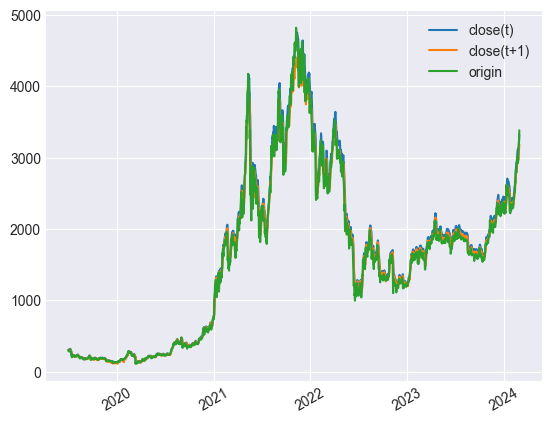

In [304]:
import matplotlib.pyplot as plt

plt.figure()
plt.xticks(rotation=30)
plt.plot(x, predictiony0, label='close(t)')
plt.plot(x, predictiony1, label='close(t+1)')
plt.plot(x, originaly, label='origin')
plt.legend()
plt.show()

In [305]:
import numpy as np
prediction = pd.DataFrame(np.concatenate((np.expand_dims(predictiony0, axis=1), np.expand_dims(predictiony1, axis=1)), axis=1), columns=['close(t)', 'close(t+1)'])
prediction.insert(0, 'date', x)
prediction.insert(1, 'origin', np.expand_dims(originaly, axis=1))

prediction

,date,origin,close(t),close(t+1)
0,2019-07-03,303.118225,303.605743,296.815887
1,2019-07-04,284.419769,309.024506,303.192932
2,2019-07-05,287.977905,304.576019,299.698120
3,2019-07-06,287.504578,303.374237,295.834229
4,2019-07-07,305.762726,296.102112,288.607697
...,...,...,...,...
1697,2024-02-24,2991.811279,3081.001465,2959.995850
1698,2024-02-25,3111.157227,3106.413086,2977.271484
1699,2024-02-26,3179.377441,3153.226562,3036.631104
1700,2024-02-27,3243.107910,3233.770508,3113.912842


In [306]:
prediction.to_csv('../data/prediction_result.csv')